In [11]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Σύνδεση με το Google Drive
drive.mount('/content/drive')

# Ελέγχουμε αν το αρχείο υπάρχει στην αναμενόμενη διαδρομή
file_path = '/content/drive/My Drive/Python Projects/Stocks/Exxon Mobil Corporation (XOM).xlsx'
print(os.path.exists(file_path))  # Αν επιστρέψει True, το αρχείο υπάρχει


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
True


In [18]:
# Φόρτωση δεδομένων από αρχείο Excel
file_path = '/content/drive/My Drive/Python Projects/Stocks/Exxon Mobil Corporation (XOM).xlsx'

# Διαβάζουμε το αρχείο Excel, αγνοώντας τυχόν κακές γραμμές
data = pd.read_excel(file_path, sheet_name=0)  # Εάν το αρχείο έχει περισσότερα από ένα φύλλα, μπορείς να επιλέξεις το φύλλο με 'sheet_name'

# Εμφάνιση των πρώτων γραμμών για να κατανοήσουμε τη διάρθρωση του αρχείου
print(data.head())

# Αντικατάσταση των μη έγκυρων στηλών (εάν υπάρχει πρόβλημα με τα ονόματα)
# Σε περίπτωση που οι στήλες είναι σε διαφορετική μορφή, μπορείτε να τις μετονομάσετε χειροκίνητα
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Φόρτωση δεδομένων και παρακάμπτοντας κακές γραμμές (π.χ. κενές τιμές)
data = data.dropna()  # Για να αφαιρέσεις τις γραμμές με κενές τιμές

# Επεξεργασία της ημερομηνίας και ταξινόμηση
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Μετατροπή σε datetime και αγνόηση κακών τιμών
data = data.sort_values(by='Date')  # Ταξινόμηση βάσει της ημερομηνίας

# Δημιουργία χαρακτηριστικών (Χ) και στόχου (y)
X = data[['Open', 'High', 'Low', 'Volume']]  # Εξαρτημένες μεταβλητές
y = data['Close']  # Στόχος

# Αντικατάσταση κενών τιμών
X = X.fillna(0)  # Αντικατάσταση κενών τιμών με 0
y = y.fillna(0)  # Αντικατάσταση κενών τιμών με 0

# Εμφάνιση δείγματος των δεδομένων
print("Δείγμα δεδομένων:")
print(X.head())
print(y.head())


  Summary   News   Chart   Conversations   Statistics   Historical Data     Proﬁle   Financials   Analysis   Options   Holders   Sustainability  \
0  NYSE - Delayed Quote •  USD\nExxon Mobil Corpo...                                                                                              
1                            Pre-Market: 4:56 AM EST                                                                                              
2                                    Currency in USD                                                                                              
3                                                NaN                                                                                              
4                                                NaN                                                                                              

  Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  
0        NaN        NaN        NaN        NaN  

<ipython-input-18-d0ef01bb8d5a>:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Μετατροπή σε datetime και αγνόηση κακών τιμών


Δείγμα δεδομένων:
       Open   High    Low      Volume
5846  37.69  38.13  36.59   9,884,600
5845     38  38.84  37.78   9,802,200
5844  38.25  38.25  37.13  10,207,800
5843     37   37.5     36  10,497,400
5842  36.06   40.5     36  22,811,600
5846    38.03
5845     38.5
5844    37.84
5843    36.47
5842       40
Name: Close, dtype: object


Πρώτες 5 γραμμές των δεδομένων:
              Date     Open     High      Low    Close  Adj Close      Volume
56    Oct 19  2022  10125.0  10399.0  10123.0  10379.0     9628.0  20921700.0
477   Feb 26  2021   5441.0   5506.0   5312.0   5437.0     4685.0  35291000.0
898    Jul 8  2019   7614.0   7670.0   7592.0   7648.0     5857.0   7876100.0
1319   Nov 9  2017   8330.0   8414.0   8308.0   8397.0     5982.0  10528800.0
1740  Mar 21  2016   8384.0   8414.0   8350.0   8362.0     5645.0   8385400.0

Περιγραφική στατιστική ανάλυση:
               Open          High           Low         Close    Adj Close  \
count     14.000000     14.000000     14.000000     14.000000    14.000000   
mean    7349.142857   7406.214286   7290.857143   7349.142857  4799.714286   
std     2185.729129   2226.939472   2196.708477   2223.714905  2080.990645   
min     3509.000000   3509.000000   3470.000000   3472.000000  1697.000000   
25%     5675.000000   5739.750000   5556.250000   5660.500000  3445.750000   

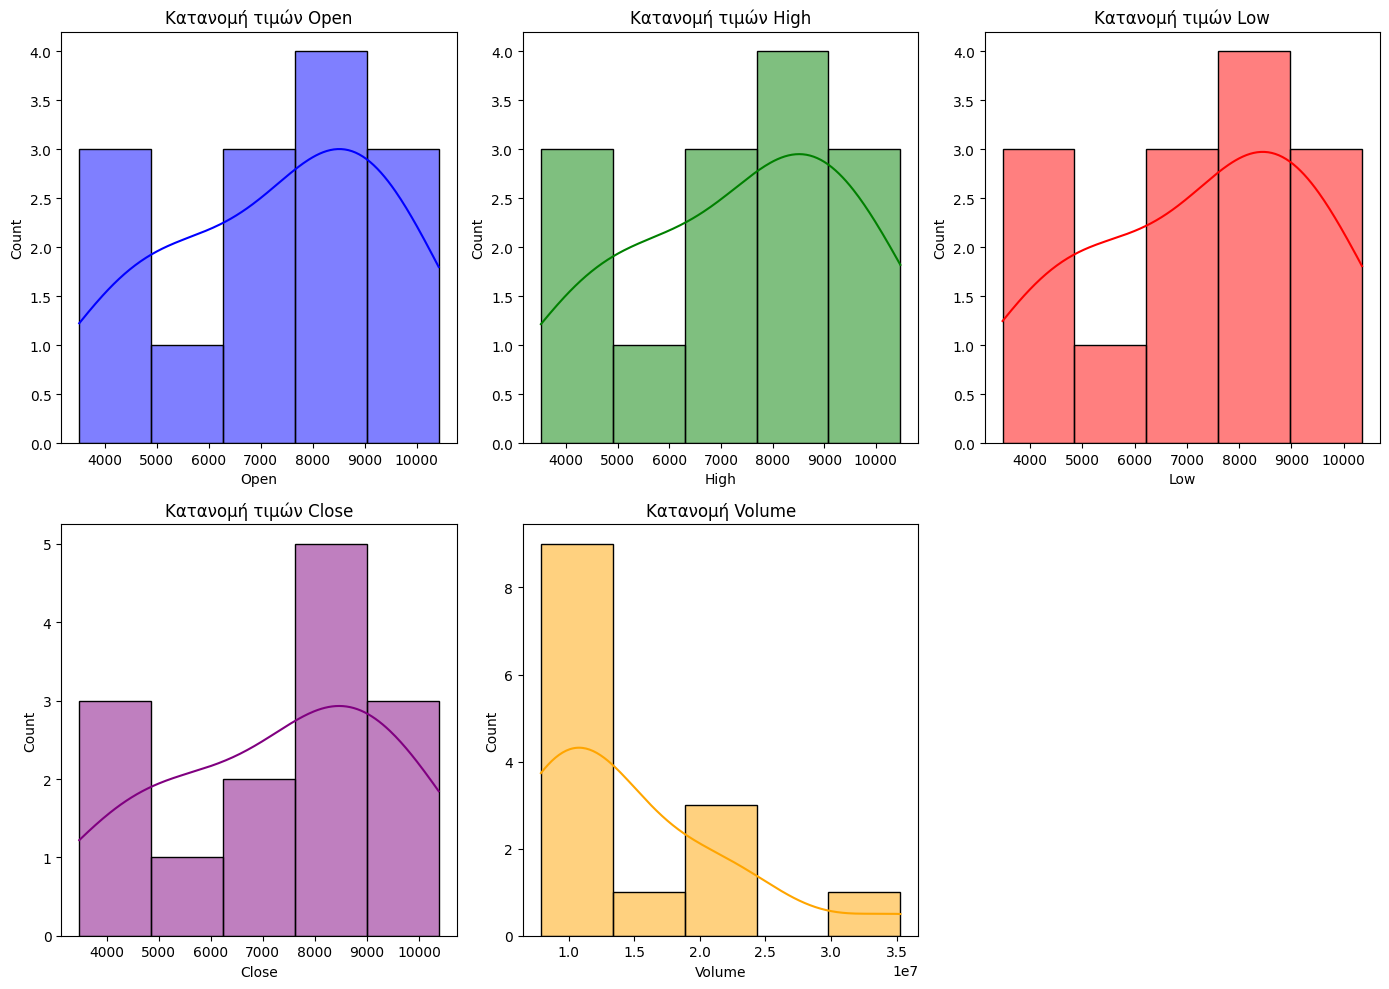

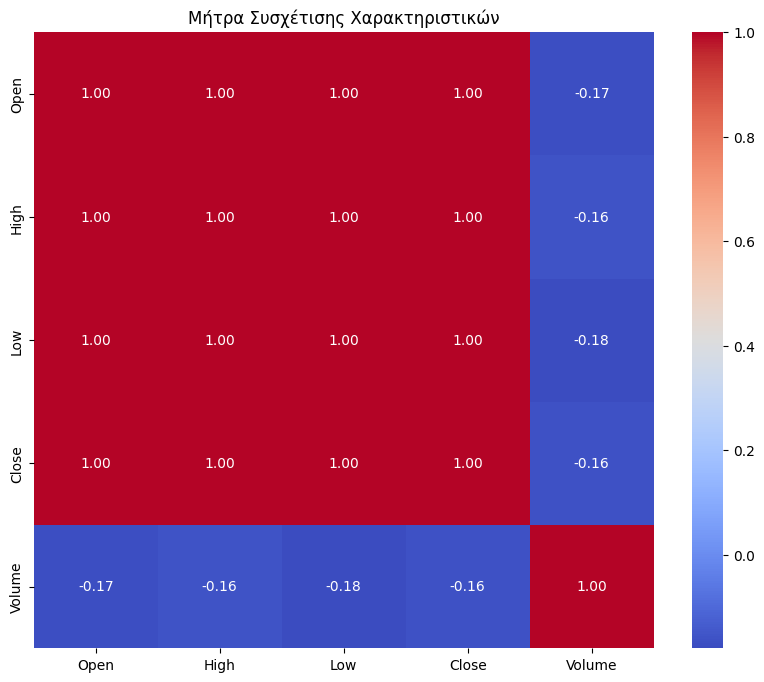

In [25]:
# Φόρτωση δεδομένων από το αρχείο Excel
file_path = '/content/drive/My Drive/Python Projects/Stocks/Exxon Mobil Corporation (XOM).xlsx'

# Φόρτωση του αρχείου και παραλείποντας τις πρώτες 2 γραμμές για επικεφαλίδες
data = pd.read_excel(file_path, sheet_name=0, skiprows=2)

# Διορθώνουμε τις επικεφαλίδες των στηλών (αν χρειαστεί)
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Καθαρισμός δεδομένων: Αφαιρούμε τις ετικέτες όπως "\n"
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    data[col] = data[col].astype(str).str.replace(r'\n', '', regex=True)
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Μετατροπή σε αριθμητικά

# Καθαρισμός: Αφαιρούμε γραμμές με μη έγκυρες τιμές (NaN) στις στήλες Open, High, Low, Close, Volume
data_cleaned = data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

# 1. Προβολή των πρώτων γραμμών των δεδομένων
print("Πρώτες 5 γραμμές των δεδομένων:")
print(data_cleaned.head())

# 2. Περιγραφική στατιστική ανάλυση
print("\nΠεριγραφική στατιστική ανάλυση:")
print(data_cleaned.describe())

# 3. Έλεγχος για κενές τιμές
print("\nΈλεγχος κενών τιμών:")
print(data_cleaned.isnull().sum())

# 4. Οπτικοποίηση των βασικών χαρακτηριστικών
plt.figure(figsize=(14, 10))

# Ιστογράμματα για τα χαρακτηριστικά 'Open', 'High', 'Low', 'Close', 'Volume'
plt.subplot(2, 3, 1)
sns.histplot(data_cleaned['Open'], kde=True, color='blue')
plt.title('Κατανομή τιμών Open')

plt.subplot(2, 3, 2)
sns.histplot(data_cleaned['High'], kde=True, color='green')
plt.title('Κατανομή τιμών High')

plt.subplot(2, 3, 3)
sns.histplot(data_cleaned['Low'], kde=True, color='red')
plt.title('Κατανομή τιμών Low')

plt.subplot(2, 3, 4)
sns.histplot(data_cleaned['Close'], kde=True, color='purple')
plt.title('Κατανομή τιμών Close')

plt.subplot(2, 3, 5)
sns.histplot(data_cleaned['Volume'], kde=True, color='orange')
plt.title('Κατανομή Volume')

plt.tight_layout()
plt.show()

# 5. Συσχέτιση των χαρακτηριστικών με τη χρήση heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = data_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Μήτρα Συσχέτισης Χαρακτηριστικών')
plt.show()


In [27]:

# Φόρτωση των δεδομένων από το αρχείο Excel
file_path = '/content/drive/My Drive/Python Projects/Stocks/Exxon Mobil Corporation (XOM).xlsx'

# Φόρτωση του αρχείου και παραλείποντας τις πρώτες 2 γραμμές για επικεφαλίδες
data = pd.read_excel(file_path, sheet_name=0, skiprows=2)

# Διορθώνουμε τις επικεφαλίδες των στηλών (αν χρειαστεί)
data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Καθαρισμός δεδομένων: Αφαιρούμε τις ετικέτες όπως "\n"
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    data[col] = data[col].astype(str).str.replace(r'\n', '', regex=True)
    data[col] = pd.to_numeric(data[col], errors='coerce')  # Μετατροπή σε αριθμητικά

# Καθαρισμός: Αφαιρούμε γραμμές με μη έγκυρες τιμές (NaN) στις στήλες Open, High, Low, Close, Volume
data_cleaned = data.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

# Συνάρτηση για τον καθαρισμό των outliers χρησιμοποιώντας IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Καθαρισμός των outliers σε όλες τις αριθμητικές στήλες
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    data_cleaned = remove_outliers(data_cleaned, col)

# Εμφάνιση των καθαρών δεδομένων στο output
print("Καθαρισμένα δεδομένα:")
print(data_cleaned)

# Αποθήκευση των καθαρών δεδομένων σε νέο αρχείο Excel
output_file_path = '/content/drive/My Drive/Python Projects/Stocks/Exxon_Mobil_Cleaned.xlsx'
data_cleaned.to_excel(output_file_path, index=False)

print(f"Τα καθαρισμένα δεδομένα αποθηκεύτηκαν στο {output_file_path}")


Καθαρισμένα δεδομένα:
              Date     Open     High      Low    Close  Adj Close      Volume
56    Oct 19  2022  10125.0  10399.0  10123.0  10379.0     9628.0  20921700.0
898    Jul 8  2019   7614.0   7670.0   7592.0   7648.0     5857.0   7876100.0
1319   Nov 9  2017   8330.0   8414.0   8308.0   8397.0     5982.0  10528800.0
1740  Mar 21  2016   8384.0   8414.0   8350.0   8362.0     5645.0   8385400.0
2161  Jul 29  2014  10421.0  10476.0  10352.0  10355.0     6604.0   8055400.0
2582   Dec 3  2012   8855.0   8858.0   8747.0   8761.0     5364.0  10937300.0
3003  Apr 11  2011   8595.0   8615.0   8478.0   8516.0     4993.0  13026500.0
3424  Aug 18  2009   6670.0   6681.0   6626.0   6649.0     3754.0  21519700.0
3845  Dec 26  2007   9368.0   9500.0   9364.0   9481.0     5161.0  15294100.0
4266   May 4  2006   6377.0   6441.0   6289.0   6331.0     3343.0  23185600.0
4687  Sep 10  2004   4759.0   4764.0   4712.0   4737.0     2426.0   9276700.0
5108  Jan 17  2003   3509.0   3509.0   347

In [28]:
# Φόρτωση των καθαρών δεδομένων από το αποθηκευμένο αρχείο Excel
cleaned_file_path = '/content/drive/My Drive/Python Projects/Stocks/Exxon_Mobil_Cleaned.xlsx'
data_cleaned = pd.read_excel(cleaned_file_path)

# Επιλέγουμε τις στήλες εισόδου (features) και τις στήλες στόχου (labels)
# Εδώ υποθέτουμε ότι η στήλη 'Close' είναι η ετικέτα (y) και οι άλλες στήλες είναι χαρακτηριστικά (X)
X = data_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']]  # Χαρακτηριστικά
y = data_cleaned['Close']  # Στόχος

# Διαχωρισμός δεδομένων σε εκπαιδευτικό και δοκιμαστικό σύνολο (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Εμφάνιση των διαστάσεων των δεδομένων
print(f"Εκπαιδευτικά δεδομένα: {X_train.shape}")
print(f"Δοκιμαστικά δεδομένα: {X_test.shape}")


Εκπαιδευτικά δεδομένα: (10, 5)
Δοκιμαστικά δεδομένα: (3, 5)


In [45]:

# Φόρτωση των καθαρών δεδομένων από το αποθηκευμένο αρχείο Excel
cleaned_file_path = '/content/drive/My Drive/Python Projects/Stocks/Exxon_Mobil_Cleaned.xlsx'
data_cleaned = pd.read_excel(cleaned_file_path)

# Επιλέγουμε τις στήλες εισόδου (features) και τις στήλες στόχου (labels)
X = data_cleaned[['Open', 'High', 'Low', 'Close', 'Volume']]  # Χαρακτηριστικά
y = data_cleaned['Close']  # Στόχος

# Κανονικοποίηση των δεδομένων με Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Διαχωρισμός δεδομένων σε εκπαιδευτικό και δοκιμαστικό σύνολο (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Ορισμός και εκπαίδευση του μοντέλου Gradient Boosting με βελτιωμένες παραμέτρους
model = GradientBoostingRegressor(
    n_estimators=200,  # Αυξημένο πλήθος δέντρων για καλύτερη απόδοση
    learning_rate=0.05,  # Χαμηλότερο learning rate για καλύτερη γενίκευση
    max_depth=6,  # Μεγαλύτερο βάθος για πιο περίπλοκες σχέσεις
    random_state=42
)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)  # 5-Fold Cross Validation
cv_results = cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')

# Μέσος όρος του RMSE από το cross-validation
mean_rmse = np.sqrt(-cv_results.mean())
print(f"Average RMSE from Cross-Validation: {mean_rmse}")

# Εκπαίδευση του μοντέλου
model.fit(X_train, y_train)

# Πρόβλεψη τιμών
y_pred = model.predict(X_test)

# Υπολογισμός του RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Υπολογισμός του R² (R-squared)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Average RMSE from Cross-Validation: 424.83167337639344
Root Mean Squared Error (RMSE): 560.704934633265
R-squared: 0.9608463515435193


In [43]:
# Αποθήκευση του μοντέλου
model_path = "/content/drive/My Drive/Python Projects/Stocks/XGBoost_XOM_Model.pkl"
joblib.dump(model, model_path)
print(f"Το μοντέλο αποθηκεύτηκε στη διαδρομή: {model_path}")


Το μοντέλο αποθηκεύτηκε στη διαδρομή: /content/drive/My Drive/Python Projects/Stocks/XGBoost_XOM_Model.pkl


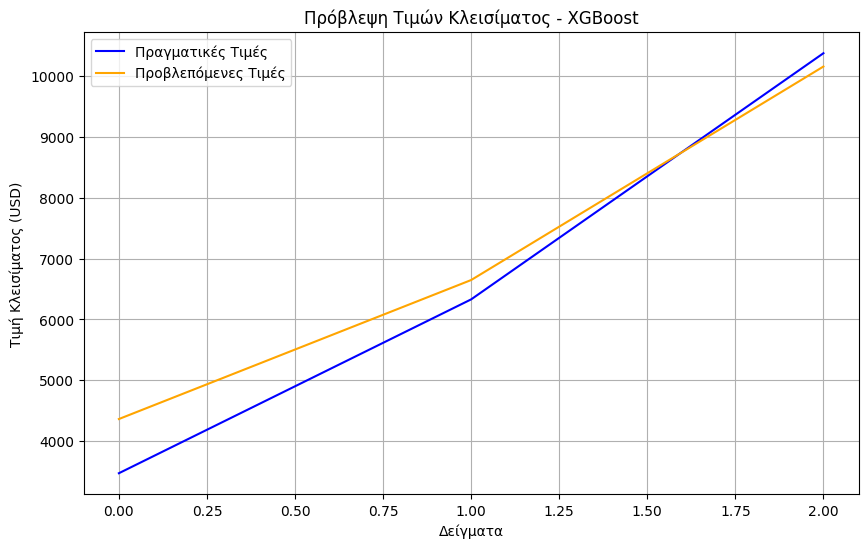

Πραγματικές Τιμές και Προβλεπόμενες Τιμές για τα πρώτα 3 δείγματα:
Δείγμα 1: Πραγματική Τιμή = 3472, Προβλεπόμενη Τιμή = 4363.117913663993
Δείγμα 2: Πραγματική Τιμή = 6331, Προβλεπόμενη Τιμή = 6649.037783268949
Δείγμα 3: Πραγματική Τιμή = 10379, Προβλεπόμενη Τιμή = 10160.0687241923


In [44]:


# Οπτικοποίηση πραγματικών και προβλεπόμενων τιμών
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test.to_numpy(), label='Πραγματικές Τιμές', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Προβλεπόμενες Τιμές', color='orange')
plt.title("Πρόβλεψη Τιμών Κλεισίματος - XGBoost")
plt.xlabel("Δείγματα")
plt.ylabel("Τιμή Κλεισίματος (USD)")
plt.legend()
plt.grid()
plt.show()

# Εμφάνιση πρώτων 10 τιμών, ή όσο είναι διαθέσιμα δείγματα
num_samples = min(10, len(y_test))  # Πόσα δείγματα υπάρχουν στο y_test

print(f"Πραγματικές Τιμές και Προβλεπόμενες Τιμές για τα πρώτα {num_samples} δείγματα:")
for i in range(num_samples):
    print(f"Δείγμα {i+1}: Πραγματική Τιμή = {y_test.to_numpy()[i]}, Προβλεπόμενη Τιμή = {y_pred[i]}")
